<a href="https://colab.research.google.com/github/ryderwishart/biblical-machine-learning/blob/main/GPPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Pretrained Pattern Transformer
The goal of this project is to train a language model using a custom relative tokenization approach. Instead of using a fixed vocabulary, the relative tokenizer assigns unique tokens to each word based on its position within a given context window. This approach forces the model to learn in-context pattern matching rather than relying on a fixed vocabulary. By generating input-output pairs dynamically for each sequence, the model is encouraged to generalize and capture patterns within the text, regardless of the specific characters involved. The ultimate aim is to create a language model that simply learns pattern matching.

### TLDR:
Goal is make it so good at pattern matching that it can learn any problem simply in the context.

In [ ]:
!git clone https://github.com/karpathy/minGPT.git

Cloning into 'minGPT'...
remote: Enumerating objects: 489, done.
remote: Total 489 (delta 0), reused 0 (delta 0), pack-reused 489
Receiving objects: 100% (489/489), 1.44 MiB | 9.26 MiB/s, done.
Resolving deltas: 100% (260/260), done.


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
import string
def rm(text):
    # Define translation table to remove punctuation
    translation_table = str.maketrans({key: None for key in string.punctuation if key != ':'})

    # Remove punctuation and convert to lowercase
    cleaned_text = text.translate(translation_table).lower()

    return cleaned_text

In [ ]:
context = """
source: Kamana hiro ka vatia a Iesus, a Pita ia tania ni Iesus, “Tisa, e kemi kua tolu ta lupu ri kua, vatia hita kata habatia kape tolu, katiu ka, katiu ke Moses, katiu ke Elaija.” A Pita beta ni lohoi lala nazia kua ia e tatania.
target: Masamuña aquichoma esaquiti Jesús manuma torrü. Auqui arrti Pedro nanti: —Maestro, urriampae nusaca auna. Supasamuna trerrü cüpahumanca, taman aemo, taman ümoti Elías quiatarrü ümoti Moisés. Pero arrti Pedro manitanatiatai, chütusiopü ümoti isane arrüa nanti.

source: Na meneja kua e lohoihoi, ‘Nazia da ta katia kua? Kagu tubu keteni pele kakavau na kagu galanga. Beta na matuha na dangea kata hovia garigari, ta puae ve kata varinongu.
target: Auqui arrti maniqui capatarrü mapensarati sane: “¿Causane caüma sobi? Itopiqui chirranrrtiquipü nauqui rratrabacaiqui ümoti. Chiñuñetempü rratrabaca au ñanaunrrü. Isüsoca ito rranqui limosnarrü pünanaqui genterrü.

source: Pale, dia tizula kamahi kua dia ta muri mai lohu, dia ka koi dia ka tani barae, ‘Paraha, Paraha, vukazia doa kirihita.’
target: Auqui opiñatai tato manio cinco, opiyotobaita tururrü, munantü: “¡Señor, Señor, aiyaübu suiñemo tururrü!”

source: Taua matoto miu na vatia kamiu dinau katiu ni ngoro. Dinau katiu za kua e lala kete ngoro vuvua, ia na moge kua kete kukuli kara kaka. Na vuna kaka kua e lala kete kukulina kara kaka motu, ia e lala kete mumuri papa matoto na lo.
target: Apapaca nabebequi. Aucuasürü aumeampatoe. Arrtü cuasürüma aume bama maquiataca, apisamute isiu yacüpucurrti Tuparrü, chauqui tücocono aboi nanaiña nüriacarrü.

source: Ia kohania na vora ke tamana katiu ki hulenia, ‘Nazia e kakatua?’
target: Auqui batasuruti ümoti taman mosorrü, ñanquitioti pünanaquiti isane arrüna pasabo.

source: Na kapiru sikul da e hilohilo za kua ia kete balika kana tisa, na vora da e hilohilo za kua kete hizanga balika kana tubu. Manumanu dia ta kohania na tubu kara ruma ni Belsebul, kubarae, da dia ta vala hiza zaha dopa na kana manumanu ve.
target: Arrti alumnorrü tiene que ataquisürüti isiatai tacanati maestro. Arrti mosorrü isiatai. Arrüñü tacanati aupatron. Arraño tacana bama imoso. ¿Uramapü sane aume, arrtü namatü iñemo choborese?

source: Muri ia hulenia kaka ruana, ‘E ziva ho tu dinau vona?’ Ia tania, ‘Ta pelea bekena vit e 100.’ Na meneja kua ia tania vona, ‘Ia, pelea ka pepa na ka dinau nu vapolungania tu pelea 80 za bekena vit.’
target: Iñataiti quiatarü esati. Ñanquitiotito pünanaquiti: “¿Carücü, mantucutu nebequi?” Nanti: “Arrüñü rrebeca cien pusaneca trigo”. Nanti capatarrü ümoti: “Carü nani quichonimiacarrü ane corobo icu arrüna tücañe nebequi. Pero caüma aiconomo ochentatai pusaneca trigo”.

source: Pale, ia kohania nuhu kua kadia dinau vona na kana tubu. Ia hulenia katiu muga, ‘E ziva matoto ka dinau na kagu tubu?’
target:”"""
context = rm(context)
actual = rm("Auqui batasuruti ümo bama ebeoma ümoti patrón, taiquianati taman. Nanti ümoti maniqui primero: “¿Mantucubu nebequi ümoti patrón?")

In [ ]:
"""
Trains a language model using relative tokenization.
"""

import os
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import tqdm
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# -----------------------------------------------------------------------------

def get_config():
    C = CN()

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/reltokengpt'

    # data
    C.data = RelativeTokenDataset.get_default_config()

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt2'

    # trainer
    C.trainer = Trainer.get_default_config()
    C.trainer.learning_rate = 5e-4
    C.trainer.batch_size = 4

    return C

# -----------------------------------------------------------------------------
class RelativeTokenizer:
    def __init__(self, context_size):
        self.context_size = context_size

    def tokenize(self, text):
        words = text.split()
        token_to_value = {'<EOP>': 0}
        value_to_token = {0: '<EOP>'}
        next_value = 1
        relative_tokens = []
        for word in words:
            if word not in token_to_value:
                token_to_value[word] = next_value
                value_to_token[next_value] = word
                next_value += 1
            relative_tokens.append(token_to_value[word])
        return relative_tokens, token_to_value, value_to_token

    def detokenize(self, relative_tokens, value_to_token):
        try:
            words = [value_to_token[value] for value in relative_tokens]
        except:
            return 'unk'
        return ' '.join(words)

    def generate_input_output_pairs(self, text):
        input_output_pairs = []
        words = text.split()
        for i in range(len(words) - self.context_size):
            context = words[i:i + self.context_size]
            output_words = words[i + 1:i + self.context_size + 1]
            relative_tokens, token_to_value, value_to_token = self.tokenize(' '.join(context))
            input_seq = relative_tokens
            output_seq = [token_to_value.get(word, token_to_value['<EOP>']) for word in output_words]
            input_output_pairs.append((input_seq, output_seq))
        return input_output_pairs

# -----------------------------------------------------------------------------
class RelativeTokenDataset(Dataset):
    @staticmethod
    def get_default_config():
        C = CN()
        C.block_size = 1000
        return C

    def __init__(self, config, data):
        self.config = config
        self.tokenizer = RelativeTokenizer(config.block_size)
        self.data = data
        self.words = data.split()

    def __len__(self):
        return len(self.words) - self.config.block_size

    def __getitem__(self, idx):
        context = self.words[idx:idx + self.config.block_size]
        output_words = self.words[idx + 1:idx + self.config.block_size + 1]
        relative_tokens, token_to_value, value_to_token = self.tokenizer.tokenize(' '.join(context))
        input_seq = relative_tokens
        output_seq = [token_to_value.get(word, token_to_value['<EOP>']) for word in output_words]
        x = torch.tensor(input_seq, dtype=torch.long)
        y = torch.tensor(output_seq, dtype=torch.long)
        return x, y

# -----------------------------------------------------------------------------

# get default config
config = get_config()
print(config)
setup_logging(config)
set_seed(config.system.seed)

# construct the training dataset
text = open('/content/fusion1.txt', 'r').read()
text = rm(text)
train_dataset = RelativeTokenDataset(config.data, text)

# construct the model
config.model.vocab_size = config.data.block_size + 1  # Add 1 for the <EOP> token
config.model.block_size = config.data.block_size
model = GPT(config.model)

# construct the trainer object
trainer = Trainer(config.trainer, model, train_dataset)


system:
    seed: 3407
    work_dir: ./out/reltokengpt
data:
    block_size: 1000
model:
    model_type: gpt2
    n_layer: None
    n_head: None
    n_embd: None
    vocab_size: None
    block_size: None
    embd_pdrop: 0.1
    resid_pdrop: 0.1
    attn_pdrop: 0.1
trainer:
    device: auto
    num_workers: 4
    max_iters: None
    batch_size: 4
    learning_rate: 0.0005
    betas: (0.9, 0.95)
    weight_decay: 0.1
    grad_norm_clip: 1.0

number of parameters: 86.59M
running on device cuda


In [ ]:
from difflib import SequenceMatcher
def dif(text1, text2):
    matcher = SequenceMatcher(None, text1, text2)
    return matcher.ratio() * 100
history = []
diff_history = []
# iteration callback
def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        history.append(trainer.loss.item())
    if trainer.iter_num % 80 == 0:
        # evaluate both the train and test score
        model.eval()
        print(trainer.iter_num % 80)
        with torch.no_grad():
            # sample from the model...
            tokenizer = RelativeTokenizer(config.data.block_size)
            completion = context

            for _ in range(900):
                relative_tokens, token_to_value, value_to_token = tokenizer.tokenize(completion)
                x = torch.tensor(relative_tokens, dtype=torch.long)[None, ...].to(trainer.device)
                logits = model(x)
                if isinstance(logits, tuple):  # Fix: Check if logits is a tuple
                    logits = logits[0]  # Take the first element of the tuple
                last_token_logits = logits[:, -1, :]
                last_token_probs = torch.softmax(last_token_logits, dim=-1)

                # Filter out tokens that are not in the current relative tokenizer
                valid_token_values = list(value_to_token.keys())
                valid_token_probs = last_token_probs[:, valid_token_values]
                valid_token_probs /= valid_token_probs.sum(dim=-1, keepdim=True)

                # Sample the next token based on the filtered probabilities
                next_token_value = torch.multinomial(valid_token_probs[0], num_samples=1).item()
                next_token = value_to_token[next_token_value]

                if next_token == '<EOP>' or next_token== '<eop>':
                    print("\n end of text")
                    break

                completion += ' ' + next_token.lower()
                if len(completion.split(' ')) > config.data.block_size - 100:
                    break
            completion = completion.split("\n")[-1].split("source:")[0]
            print(completion)
            print("target similarity: "+str(dif(completion, actual)))
            diff_history.append(dif(completion, actual))

        # save the latest model
        print("saving model")
        ckpt_path = os.path.join(config.system.work_dir, "model.pt")
        torch.save(model.state_dict(), ckpt_path)
        # revert model to training mode
        model.train()

trainer.set_callback('on_batch_end', batch_end_callback)

# run the optimization
trainer.run()

iter_dt 239.51ms; iter 0: train loss 5.04536
0
target:” na target: pelea mai esaquiti elías tubu sikul e nanaiña vatia choborese ito kamana cien ta masamuña lohu esaquiti kua cüpahumanca mapensarati barae target: beta ‘ta moses pünanaqui auqui target: urriampae target: katiu meneja quiatarrü barae dangea maniqui na lala tubu’ kukulina varinongu aboi vatia chauqui arrti moses maquiataca dia kara katia auna hizanga ümoti manitanatiatai maquiataca pedro cüpahumanca aumeampatoe aucuasürü za tania iesus tubu’ ümoti torrü tatania kakatua’ hilohilo tubu dangea tatania vora manumanu señor belsebul arrti ümoti kakavau manuma na au hiro “tisa dangea opiñatai trerrü na munantü: matoto habatia muga rratrabaca hita auna chiñuñetempü kua ‘paraha maquiataca target: hita ni muri hiza auna ñanquitioti vuna choborese quichonimiacarrü matoto tisa kemi ia dia moisés target: rrebeca keteni moses auna kete ki rranqui barae hita genterrü chütusiopü tücañe pünanaquiti target: nüriacarrü “¿carücü cien nüriacar

KeyboardInterrupt: 

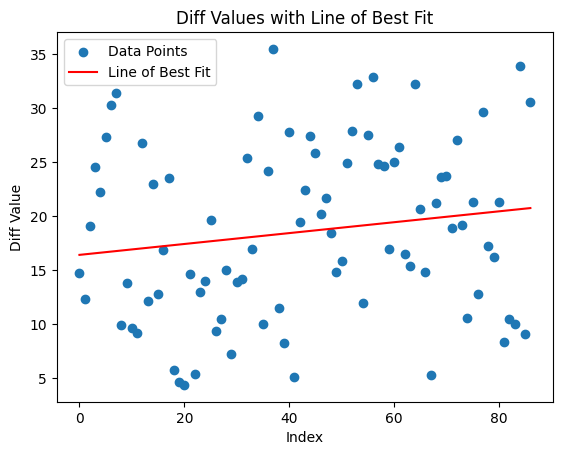

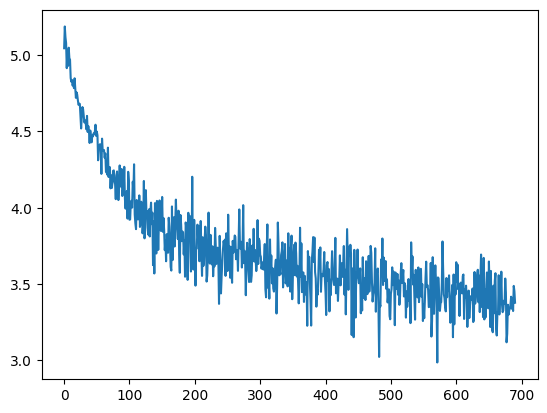

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot history and diff, with lines of best fit

x = np.arange(len(diff_history))

plt.scatter(x, diff_history, label='Data Points')

# Calculate the line of best fit
m, b = np.polyfit(x, diff_history, 1)  # Linear fit (degree 1)

# Plot the line of best fit
plt.plot(x, m*x + b, color='red', label='Line of Best Fit')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Diff Value')
plt.title('Diff Values with Line of Best Fit')
plt.legend()

# Show the plot
plt.show()
# plot history
plt.plot(history)
plt.show()

## Interesting results:
- "Today it will be rainy"
- "in spring it will be frosty."

## With context
german: heute ist es sonnig.
english: today it is sunny.

german: heute ist es warm.
english: today it is warm.

german: morgen wird es regnerisch.
english: tomorrow it will be rainy.

german: morgen wird es kühl.
english: tomorrow it will be cool.

german: am wochenende wird es bewölkt.
english: on the weekend it will be cloudy.

german: am wochenende wird es windig.
english: on the weekend it will be windy.

german: nächste woche wird es schneien.
english: next week it will snow.

german: nächste woche wird es frostig.
english: next week it will be frosty.

german: gestern war es neblig.
english: yesterday it was foggy.

german: gestern war es kalt.
english: yesterday it was cold.

german: letzte nacht gab es gewitter.
english: last night there were thunderstorms.

german: letzte nacht gab es blitze.
english: last night there was lightning.

german: im frühling ist es mild.
english: in spring it is mild.

german: heute ist es neblig.

english:

output:

`today it is sunny.`

should be:

`today it is foggy.`



french: j'ai acheté un iphone x pour mon anniversaire. italian: ho comprato un iphone x per il mio compleanno.
french: les caractéristiques de mon iphone sont vraiment inc italian: le caratteristiche del mio iphone sono veramente in
french: j'ai téléchargé l'application facebook sur mon iphon italian: ho scaricato l'applicazione facebook sul mio iphone
french: mon iphone a une batterie qui dure très longtemps.
italian: il mio iphone ha una batteria che dura molto a lung
french: j'ai mis à jour mon iphone avec l'assistant virtuel. italian: ho aggiornato il mio iphone con l'assistente virtua
french: les jeux sur mon iphone sont vraiment amusants.
italian: i giochi sul mio iphone sono veramente divertenti.
french: je suis perdu sans mon iphone.
italian: sono perso senza il mio iphone.
french: mon iphone a une caméra très bonne.
italian: il mio iphone ha una fotocamera molto buona.
french: j'ai vendu mon iphone usagé sur le marché. italian: ho venduto il mio iphone usato sul mercato.
french: je préfère l'iphone à tous les autres smartphones. italian: preferisco l'iphone a tutti gli altri smartphone.
french: mon iphone est vraiment facile à utiliser.


italian:

 il mio iphone sono veramente facile a il utiliser.


 ## Feedback:

The original sentence in Italian, "il mio iphone sono veramente facile a il utiliser," is understandable but has several grammatical errors. Here's a breakdown of the issues:

Subject-Verb Agreement: "Il mio iPhone" is singular, so the verb should be "è" (is) instead of "sono" (are).
Incorrect Preposition: "a" should be replaced with "da" when saying "easy to use."
Language Mixing: The word "utiliser" is French, not Italian. The correct Italian verb is "usare."
Here's the corrected version:

"Il mio iPhone è veramente facile da usare."

This correction makes the sentence grammatically correct and natural in Italian.